In [1]:
import keras

Using TensorFlow backend.


In [2]:
from keras.models import Sequential
from keras.utils.np_utils import to_categorical
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, AvgPool2D, BatchNormalization, Reshape
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler

In [3]:
model = Sequential()
model.add(Conv2D(32, kernel_size=3, padding='same', activation='relu', input_shape=(32, 32, 1)))
model.add(MaxPool2D(pool_size=2))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dense(43, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [4]:
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** (x + epochs))
epochs = 15

In [5]:
import pickle

In [6]:
with open('ToySet1.pickle', 'rb') as f:
    data = pickle.load(f, encoding='latin1')

In [7]:
data['y_train'] = to_categorical(data['y_train'], num_classes=43)
data['y_validation'] = to_categorical(data['y_validation'], num_classes=43)

# Making channels come at the end
data['x_train'] = data['x_train'].transpose(0, 2, 3, 1)
data['x_validation'] = data['x_validation'].transpose(0, 2, 3, 1)
data['x_test'] = data['x_test'].transpose(0, 2, 3, 1)

# Showing loaded data from file
for i, j in data.items():
    if i == 'labels':
        print(i + ':', len(j))
    else: 
        print(i + ':', j.shape)

x_train: (540, 32, 32, 1)
y_train: (540, 43)
x_validation: (90, 32, 32, 1)
y_validation: (90, 43)
x_test: (180, 32, 32, 1)
y_test: (180,)
labels: 43


In [8]:
h = model.fit(data['x_train'][:540], data['y_train'][:540],
              batch_size=5, epochs = epochs,
              validation_data = (data['x_validation'], data['y_validation']),
              callbacks=[annealer], verbose=1)

Train on 540 samples, validate on 90 samples
Epoch 1/15
540/540 [==============================] - 7s 14ms/step - loss: 9.7683 - accuracy: 0.8611 - val_loss: 9.2718e-09 - val_accuracy: 1.0000
Epoch 2/15
540/540 [==============================] - 7s 13ms/step - loss: 1.4763 - accuracy: 0.9741 - val_loss: 0.5204 - val_accuracy: 0.9778
Epoch 3/15
540/540 [==============================] - 7s 13ms/step - loss: 0.1424 - accuracy: 0.9963 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/15
540/540 [==============================] - 7s 13ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/15
540/540 [==============================] - 7s 13ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/15
540/540 [==============================] - 7s 13ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/15
540/540 [==============================] - 7s 13ms/ste

In [9]:
#Confution Matrix and Classification Report
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
Y_pred = model.predict(data['x_validation'])
y_pred = np.argmax(Y_pred, axis=1)
y_val = np.argmax(data['y_validation'],axis=1)
print('Confusion Matrix')
print(confusion_matrix(y_val, y_pred))
print('Classification Report')
#target_names = ['Cats', 'Dogs', 'Horse']
print(classification_report(y_val, y_pred))

Confusion Matrix
[[30  0  0]
 [ 0 30  0]
 [ 0  0 30]]
Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       1.00      1.00      1.00        30
           2       1.00      1.00      1.00        30

    accuracy                           1.00        90
   macro avg       1.00      1.00      1.00        90
weighted avg       1.00      1.00      1.00        90



In [10]:
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
import matplotlib.pyplot as plt

In [11]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(43):
    fpr[i], tpr[i], _ = roc_curve(data['y_validation'][:,i], Y_pred[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(data['y_validation'].ravel(), Y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

/Users/davidy.jkim/anaconda3/lib/python3.7/site-packages/sklearn/metrics/ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


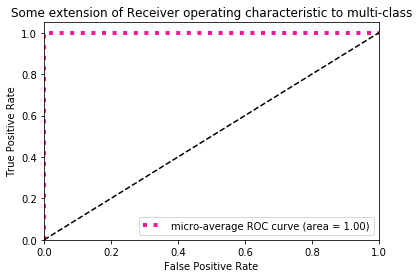

In [13]:
# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(43)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(43):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= 43

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

'''
plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)
'''
'''
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(43), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
    '''

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [14]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(43):
    precision[i], recall[i], _ = precision_recall_curve(data['y_validation'][:,i], Y_pred[:,i])
    average_precision[i] = average_precision_score(data['y_validation'][:,i], Y_pred[:,i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(data['y_validation'].ravel(),
    Y_pred.ravel())
average_precision["micro"] = average_precision_score(data['y_validation'], Y_pred,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

Average precision score, micro-averaged over all classes: 1.00


/Users/davidy.jkim/anaconda3/lib/python3.7/site-packages/sklearn/metrics/ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Text(0.5, 1.0, 'Average precision score, micro-averaged over all classes: AP=1.00')

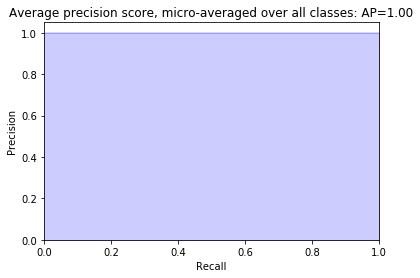

In [15]:
from inspect import signature
# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})


plt.figure()
plt.step(recall['micro'], precision['micro'], color='b', alpha=0.2,
         where='post')
plt.fill_between(recall["micro"], precision["micro"], alpha=0.2, color='b',
                 **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision["micro"]))